In [12]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from rdkit.Geometry.rdGeometry import Point3D
# 显示图片
import Phe2BCH

import py3Dmol
def drawit(m,p=None,confId=-1):
        mb = Chem.MolToMolBlock(m,confId=confId)
        if p is None:
            p = py3Dmol.view(width=400,height=400)
        p.removeAllModels()
        p.addModel(mb,'sdf')
        p.setStyle({'stick':{}})
        p.setBackgroundColor('0xeeeeee')
        p.zoomTo()
        return p.show()

def mol_with_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for idx in range(atoms):
        mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber',str(idx))
    return mol

In [25]:
ligands_smi = {}
with open("/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/lig_menu/AaaaA_only3.csv") as AaaaA:
    for line in AaaaA:
        info = line.split()
        ligands_smi[info[1]] = [info[0]]
inp = "RFQ_4d3u"
key = inp.split("_")[0]
pdb_id=inp.split("_")[1]
lig_smi=ligands_smi[key][0]
# print(lig_smi)
pdb_path = f"/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/pdb_dataset/pdb/pdb{pdb_id}.ent"


# lig_Block = Phe2BCH.exctract_ligand_from_pdb(pdb_path,key,lig_smi,f"{key}_{pdb_id}_sin.pdb")



# test = Phe2BCH.phe2bch_topdb(lig_smi,lig_Block,f"{key}_{pdb_id}_bch.pdb")
# drawit(test)


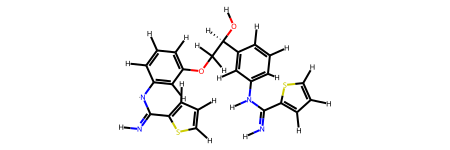

In [26]:
lig_inp = Chem.MolFromSmiles(lig_smi)
lig_inp = Chem.AddHs(lig_inp)
lig_inp


In [21]:
def exctract_ligand(pdb_path, lig_id, smiles):
    # 抽取pdbfile中的ligand部分,获得rdkit可读字符串形式的pdbBlock
    # 并加氢重命名后以pdb格式储存在outfile中
    mol_from_smi = Chem.MolFromSmiles(smiles)
    num = mol_from_smi.GetNumAtoms()
    # print(num)
    ligand_lines = []
    with open(pdb_path) as ent:
        for line in ent:
            if line[0:6] == "HETATM" and line[17:20] == lig_id:
                ligand_lines.append(line[0:78] + "  \n")
    # print("".join(ligand_lines))
    # print(ligand_lines)
    ligand_start = 0
    ligand_end = len(ligand_lines)
    for i in range(1, len(ligand_lines)):
        if ligand_lines[i][17:26] != ligand_lines[i - 1][17:26]:
            # print(ligand_lines[i][17:26])
            ligand_end = i
            if ligand_end - ligand_start >= num:
                break
            else:
                ligand_start = i
                ligand_end = len(ligand_lines)
        else:
            pass
    # print(ligand_end)
    # print(ligand_start)

    if ligand_end - ligand_start <= 2 * num:
        # avoid the altLoc is not A
        altLoc = ligand_lines[ligand_start][16]
        print(altLoc)
        # print(f"altLoc {altLoc}")
        if altLoc == "A" or altLoc == " " or altLoc == "1":
            lig_Block = "".join(ligand_lines[ligand_start:ligand_end])
        else:
            lig_Block = ""
            print("test")
            for line in ligand_lines[ligand_start:ligand_end]:
                print(line[16])
                if line[16] == altLoc:
                    lig_Block += line
            print(lig_Block)

    else:
        lig_Block = "".join(ligand_lines[ligand_start : ligand_start + num])
    print(lig_Block)
    lig_pdb = Chem.MolFromPDBBlock(lig_Block,flavor=1)
    return lig_pdb

In [28]:
lig_Block = exctract_ligand(pdb_path,key,lig_smi)
bonded_conf = lig_Block.GetConformer()
drawit(lig_Block)

 
HETATM 2983  S01 RFQ A 904       1.777  19.378  24.105  1.00 58.22           S  
HETATM 2984  C02 RFQ A 904       2.507  20.680  23.322  1.00 45.10           C  
HETATM 2985  C03 RFQ A 904       3.889  20.585  23.529  1.00 41.46           C  
HETATM 2986  C04 RFQ A 904       4.306  19.488  24.287  1.00 27.91           C  
HETATM 2987  C05 RFQ A 904       3.207  18.730  24.695  1.00 46.43           C  
HETATM 2988  C06 RFQ A 904       3.045  17.475  25.474  1.00 46.29           C  
HETATM 2989  N07 RFQ A 904       3.772  16.394  25.153  1.00 46.62           N  
HETATM 2990  N08 RFQ A 904       2.216  17.439  26.438  1.00 39.28           N  
HETATM 2991  C11 RFQ A 904       4.467  16.185  23.996  1.00 40.91           C  
HETATM 2992  C12 RFQ A 904       3.943  16.488  22.732  1.00 37.84           C  
HETATM 2993  C13 RFQ A 904       4.690  16.220  21.575  1.00 39.64           C  
HETATM 2994  C14 RFQ A 904       5.952  15.632  21.662  1.00 36.72           C  
HETATM 2995  C15 RFQ A 904

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
def getconf_from_missingatom_pdb(refmol,inpmol):
    inpmol = Chem.AddHs(inpmol)
    AllChem.EmbedMolecule(inpmol, maxAttempts=50000)
    inpmol = Chem.RemoveAllHs(inpmol)

    mcs = rdFMCS.FindMCS([refmol, inpmol],timeout=3, completeRingsOnly=True,bondCompare=rdFMCS.BondCompare.CompareAny)
    if not mcs.queryMol:
        raise ValueError("there are too many missing atoms")
    bonded_conf = refmol.GetConformer()
    conf_res = inpmol.GetConformer()
    inpmol_prop = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(inpmol)
    if inpmol_prop:
        ff_mcs = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(inpmol, inpmol_prop)
    else:
        ff_mcs = Chem.rdForceFieldHelpers.UFFGetMoleculeForceField(inpmol)

    print(refmol.GetSubstructMatch(mcs.queryMol))
    for i, j in zip(refmol.GetSubstructMatch(mcs.queryMol), inpmol.GetSubstructMatch(mcs.queryMol)):
        ff_mcs.AddFixedPoint(j)
        conf_res.SetAtomPosition(j, bonded_conf.GetAtomPosition(i))
    for i in range(10):
        try:
            ff_mcs.Minimize()
            pass
        except:
            pass
    Chem.MolToPDBBlock(inpmol)
    return inpmol

In [ ]:
drawit(getconf_from_missingatom_pdb(lig_Block,lig_inp))


ValueError: rrrrr

In [17]:
lig_from_smi = Chem.MolFromSmiles(lig_smi)
lig_from_smi
mol = Phe2BCH.phe2bch_with_smiles(lig_smi)
Chem.AddHs(mol)
# AllChem.EmbedMolecule(mol, maxAttempts=50000)
mol = Chem.RemoveAllHs(mol)
# drawit(mol)

In [11]:
lig_smi = "O=C1NC(=O)C(=CC23CCCC(C(F)(F)F)(C2)C3)S1"
lig_from_smi = Chem.MolFromSmiles(lig_smi)
lig_from_smi
# mol = Phe2BCH.phe2bch_with_smiles(lig_smi)
Chem.AddHs(lig_from_smi)
AllChem.EmbedMolecule(lig_from_smi, maxAttempts=500)
mol = Chem.RemoveAllHs(lig_from_smi)
drawit(lig_from_smi)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
ligands_smi = {}
with open(
        "/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/lig_menu/AaaaA_only4.csv"
    ) as AaaaA:
        for line in AaaaA:
            info = line.split()
            ligands_smi[info[1]] = [info[0],False]
    # print(1)
with open(
        "/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/PHE2BCH_pairs/pdb_dataset/cc-to-pdb.tdd"
    ) as ligs:
        for line in ligs:
            info = line.split()
            if info[0] in ligands_smi.keys():
                ligands_smi[info[0]].append(info[1:])
                ligands_smi[info[0]][1] = True
    # print(2)
count = 0
for key in ligands_smi:
    count += 1
    if ligands_smi[key][1]:
        for pdbid in ligands_smi[key][2]:
            print(f"{count} {key}_{pdbid}")

1 009_3ckr
2 012_3ckp
4 038_3kyr
5 03Q_3pp0
6 043_3saz
7 059_2pj6
8 069_2wa4
9 06Z_3rjc
10 07Q_3tv7
11 07R_3twj
12 0FS_3vc4
14 0GO_3veu
15 0J7_4dds
16 0K9_4di2
17 0KF_3vo3
18 0N3_4e3i
19 0OO_4eh7
20 0OP_4eh8
21 0RY_4f1l
22 0RZ_4f1q
23 0UQ_4fm8
24 0V7_4fph
25 0V8_4fpy
26 0YZ_4h3c
27 11B_2pj5
28 11R_2cg1
29 14D_4hej
30 14W_1foi
30 14W_1qwc
30 14W_1qw5
31 15V_4hge
32 160_1nmq
33 16F_3mrv
34 16K_4ek8
35 16U_3dt0
36 16W_4hnf
36 16W_4hni
37 16X_2x4f
38 183_1u1f
39 18P_3u6a
40 19U_2zfp
41 1AW_3f3u
42 1D9_4ibj
43 1FB_4ihp
43 1FB_5f0a
44 1FO_4iqv
44 1FO_4iqt
45 1FV_4im0
45 1FV_6qau
45 1FV_4iwq
46 1H4_4iwo
47 1LC_4jg7
48 1N6_4jx7
49 1NH_1o1s
50 1QE_4ugm
50 1QE_4kci
51 1QU_4k9h
52 1RG_4qu3
52 1RG_4gcs
52 1RG_3zgp
52 1RG_7kgn
52 1RG_7kgm
52 1RG_3m6b
52 1RG_6skr
52 1RG_6p99
53 1RI_7f8g
54 1SF_4kpz
55 1SI_7f8h
56 1VJ_4oyb
57 1WS_4bkz
58 1ZC_4oym
59 21U_2zgb
60 21Z_3rni
61 22O_3mta
62 22U_2zc9
62 22U_5mls
63 22X_3km4
64 235_2pj7
65 23D_2f57
65 23D_2izt
65 23D_6guf
65 23D_2cdz
66 23U_3dhk
66 23U_5mjt
